# Exercise 1

## 1.

In [1]:
import torch
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from typing import TypeVar, List, Optional, Tuple
pyro.set_rng_seed(0)

T = TypeVar('T')


In [2]:
def gibbs_sampler(rho: T, mu1: T, mu2: T, sigma1: T, sigma2: T, warmup: Optional[int] = 100, 
                  iters: Optional[int] = 1000 ) -> List:
    '''
    Implement a Gibbs sampler which takes as inputs the number of warmup draws warmup , the number of iterations
    iters and the parameters rho, mu1, mu2, sigma1, sigma2 .
    '''
    # initialization 
    data = [[], []]    
    x2 = 10
    x12_mean = mu1 + (rho / (sigma2 ** 2)) * (x2 - mu2)
    x12_variance = sigma1 ** 2 - (rho ** 2) / (sigma1 ** 2)
    x1 = pyro.sample("x1_start", dist.Normal(x12_mean, x12_variance))
    
    # warmup
    for i in range(warmup):
        x21_mean = mu2 + (rho / (sigma1 ** 2)) * (x1 - mu1)
        x21_variance = sigma2 ** 2 - (rho ** 2) / (sigma2 ** 2)
        x2 = pyro.sample("x2_warmup", dist.Normal(x21_mean, x21_variance))
        x12_mean = mu1 + (rho / (sigma2 ** 2)) * (x2 - mu2)
        x12_variance = sigma1 ** 2 - (rho ** 2) / (sigma1 ** 2)
        x1 = pyro.sample("x1_warmup", dist.Normal(x12_mean, x12_variance))
        
    data[0].append(x1)
    data[1].append(x2)

    # actual distributions calulation
    for i in range(iters - warmup):
        x21_mean = mu2 + (rho / (sigma1 ** 2)) * (data[0][i] - mu1)
        x21_variance = sigma2 ** 2 - (rho ** 2) / (sigma2 ** 2)
        data[1].append(pyro.sample("x2", dist.Normal(x21_mean, x21_variance)))
        x12_mean = mu1 + (rho / (sigma2 ** 2)) * (data[1][i] - mu2)
        x12_variance = sigma1 ** 2 - (rho ** 2) / (sigma1 ** 2)
        data[0].append(pyro.sample("x1", dist.Normal(x12_mean, x12_variance)))
        
    return data

## 2.

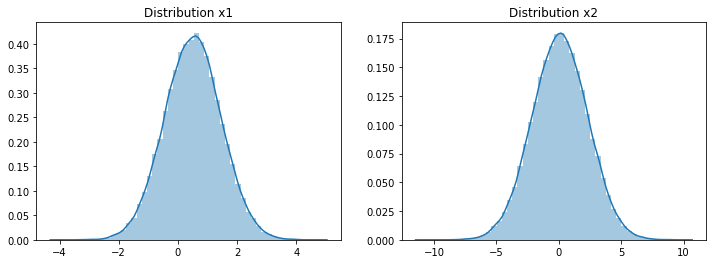

In [5]:
data = gibbs_sampler(0.3, 0.5, 0.1, 1, 1.5, 2000, 100000)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(data[0], ax=axes[0])
sns.distplot(data[1], ax=axes[1])
axes[0].set_title('Distribution x1')
axes[1].set_title('Distribution x2')
plt.show()

## 3.

\begin{align}
\end{align}

We know that
\begin{align}
&p(x_1,x_2) = p(x_1)p(x_2|x_1)\\
&p(x_1,x_2) = p(x_2)p(x_1|x_2)
\end{align}
And by Bayes rule:
\begin{align}
&p(x_2|x_1)=\frac{p(x_1|x_2)p(x_2)}{p(x_1)}\\
\Rightarrow & p(x_1)= \frac{p(x_1|x_2)p(x_2)}{p(x_2|x_1)}
\end{align}
So
\begin{align}
&p(x_1,x_2) = p(x_1)p(x_2|x_1) =\frac{p(x_1|x_2)p(x_2)p(x_2|x_1)}{p(x_2|x_1)} \\
\end{align}

# Exercise 2

## 1.

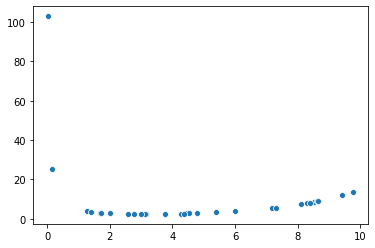

Warmup:  25%|██▍       | 519/2100 [00:39, 10.43it/s, step size=6.33e-07, acc. prob=0.767]

In [7]:
def generate_obs(theta1: T, theta2: T, obs: Optional[int] = 30) -> List:
    '''
    
    '''
    
    data = [[],[]]
    
    for i in range(obs):
        rho = pyro.sample("rho", dist.Normal(0, 0.3**2))
        x = pyro.sample("x", dist.Uniform(0, 10)).item()
        data[0].append(x)
        y = (math.e ** (theta1 * x) + theta2)/x + rho
        data[1].append(y)
    
    return data       
data = generate_obs(0.5, 3, 30)
sns.scatterplot(data[0], data[1])
plt.show()            

## 2.

In [8]:
def noisy_obs(obs: T) -> None:
    '''
    
    '''
    x_obs = torch.tensor(obs[0])
    y_obs = torch.tensor(obs[1])
    theta1 = pyro.sample("theta1", dist.Exponential(2.))
    theta2 = pyro.sample("theta2", dist.Exponential(0.2))
    gamma = pyro.sample("gamma", dist.Uniform(0,0.5))
    y = [(math.e ** (theta1 * obs[0][i]) + theta2)/obs[0][i] for i in range(len(x_obs))] 
    y = torch.tensor(y)
    pyro.sample("y", dist.Normal(y, gamma), obs=y_obs)
    

In [13]:
kernel = NUTS(noisy_obs)
mcmc = MCMC(kernel, warmup_steps=2000, num_samples=100, num_chains=2)
mcmc.run(obs=data)
mcmc.summary()

Warmup [1]:   0%|          | 0/2100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2100 [00:00, ?it/s]

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/api.py", line 101, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/api.py", line 113, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/hmc.py", line 302, in setup
    self._initialize_model_properties(args, kwargs)
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/hmc.py", line 244, in _initialize_model_properties
    init_params, potential_fn, transforms, trace = initialize_model(
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/util.py", line

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/api.py", line 101, in run
    for sample in _gen_samples(self.kernel, self.warmup_steps, self.num_samples, logging_hook,
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/api.py", line 113, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/hmc.py", line 302, in setup
    self._initialize_model_properties(args, kwargs)
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/hmc.py", line 244, in _initialize_model_properties
    init_params, potential_fn, transforms, trace = initialize_model(
  File "/home/showreally/.local/lib/python3.8/site-packages/pyro/infer/mcmc/util.py", line

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork

## 4.

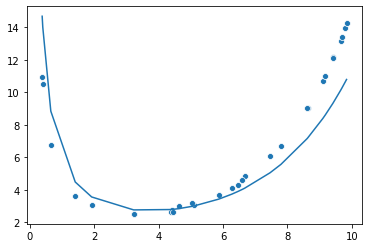

In [28]:
new_data = [data[0],[(math.e ** (0.47 * data[0][i]) + 4.37)/data[0][i] for i in range(len(data[0]))]]
sns.scatterplot(data[0], data[1])
sns.lineplot(x=new_data[0], y=new_data[1])
plt.show()   